# Tutorial 1: Pneumonia Model - ROC Analysis

## 1. Load All Necessary Libraries
### Ensure that you are running this notebook in the correct kernel.
### If needed, install the required libraries by uncommenting the following line:

For installation:


In [ ]:
#!pip install --upgrade pandas numpy matplotlib rhino_health

In [16]:
import pandas as pd
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
from getpass import getpass
import json
import io
import base64
import rhino_health as rh
from rhino_health.lib.metrics import RocAuc, RocAucWithCI
from rhino_health import ApiEnvironment


### 1.1 Logging into the Rhino Health Platform

**Replace the values with the following variables:**

1. **my_username** – Your Rhino Health Platform username.
2. **password** – Your Rhino Health Platform password.

In [17]:
my_username = 'daniel.david@rhinohealth.com'                                           

print("Logging In")
session = rh.login(username=my_username, password=getpass(), rhino_api_url= ApiEnvironment.STAGING_AWS_URL)
print("Logged In")

Logging In
You are not using the latest version of the Rhino SDK.
Latest version: 2.1.3
Current version: 2.1.1
To upgrade, run: pip install --upgrade rhino_health
Logged In


### 1.2 Load the results dataset from the project 
Start by getting your results dataset uid from the UI and pasting it below

In [ ]:
site1_results_dataset = "caa6126b-f5c2-44a3-a55d-3e1bd66fdbb9" # Replace with your dataset UID here as string
dataset = session.dataset.get_dataset(site1_results_dataset)
print(f"Loaded dataset '{dataset.name}'")

Loaded dataset 'tutorial_addBMI_complete_output'


### 1.3     Calculate ROC (underlying results data stays on-prem)

In [19]:
metric_configuration = RocAuc(y_true_variable="Pneumonia", y_pred_variable="Model Score")
results = dataset.get_metric(metric_configuration)

### 1.4     Plot the ROC with your favorite plotting tool

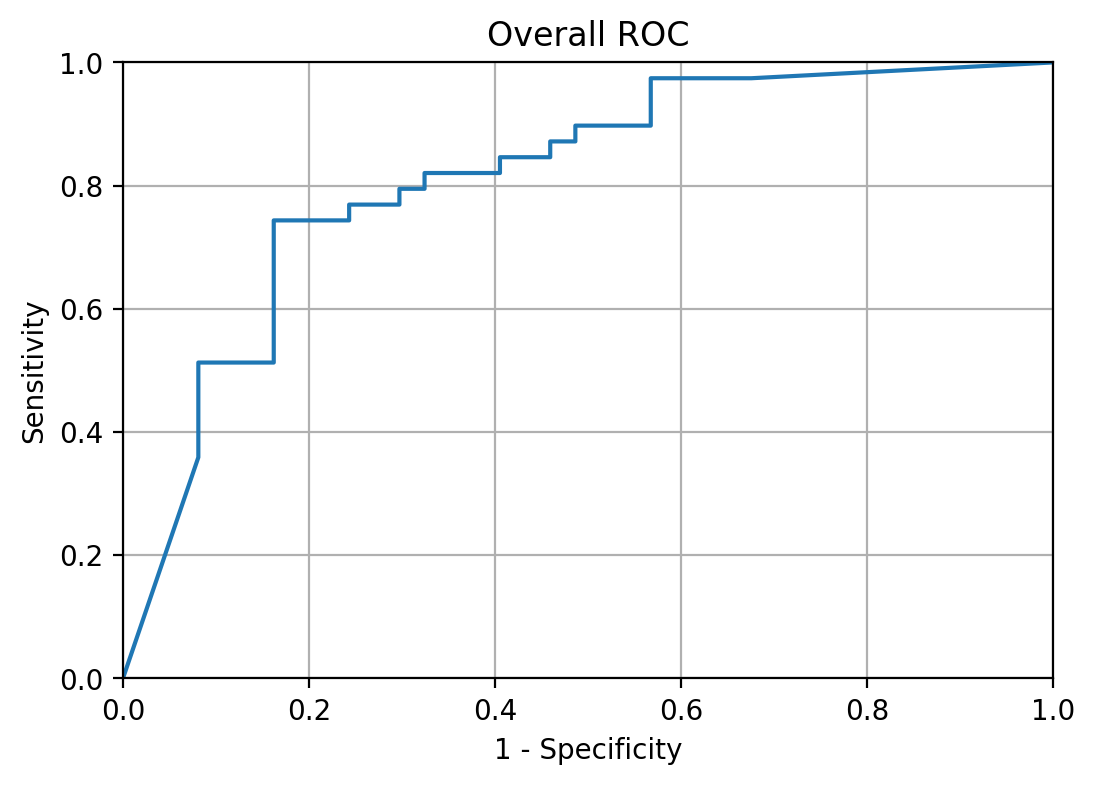

In [20]:
# Step 1: Plot your ROC curve (this part you already had)
roc_metrics = results.output

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle = ['-', '--']
fig, ax = plt.subplots(figsize=[6, 4], dpi=200)

color = colors[0]
linestyle = linestyle_cycle[0]

ax.plot(roc_metrics['fpr'], roc_metrics['tpr'], color=color, linestyle=linestyle)
ax.title.set_text('Overall ROC')
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Step 2: Render to canvas and capture image (this is the new part)
fig.canvas.draw()

buf = io.BytesIO()
fig.savefig(buf, format='png', dpi=200)
buf.seek(0)

# Step 3: Convert to PIL Image and save
image_to_store = Image.open(buf)
image_to_store.save("Overall_ROC.png", format='png', optimize=True, quality=100)

buf.close()

### 1.5 Calculate and plot ROC with a Confidence Interval

In [21]:
metric_configuration = RocAucWithCI(
   timeout_seconds = 30.0,
    y_true_variable="Pneumonia",
    y_pred_variable="Model Score",
    confidence_interval=95
)
results = dataset.get_metric(metric_configuration)

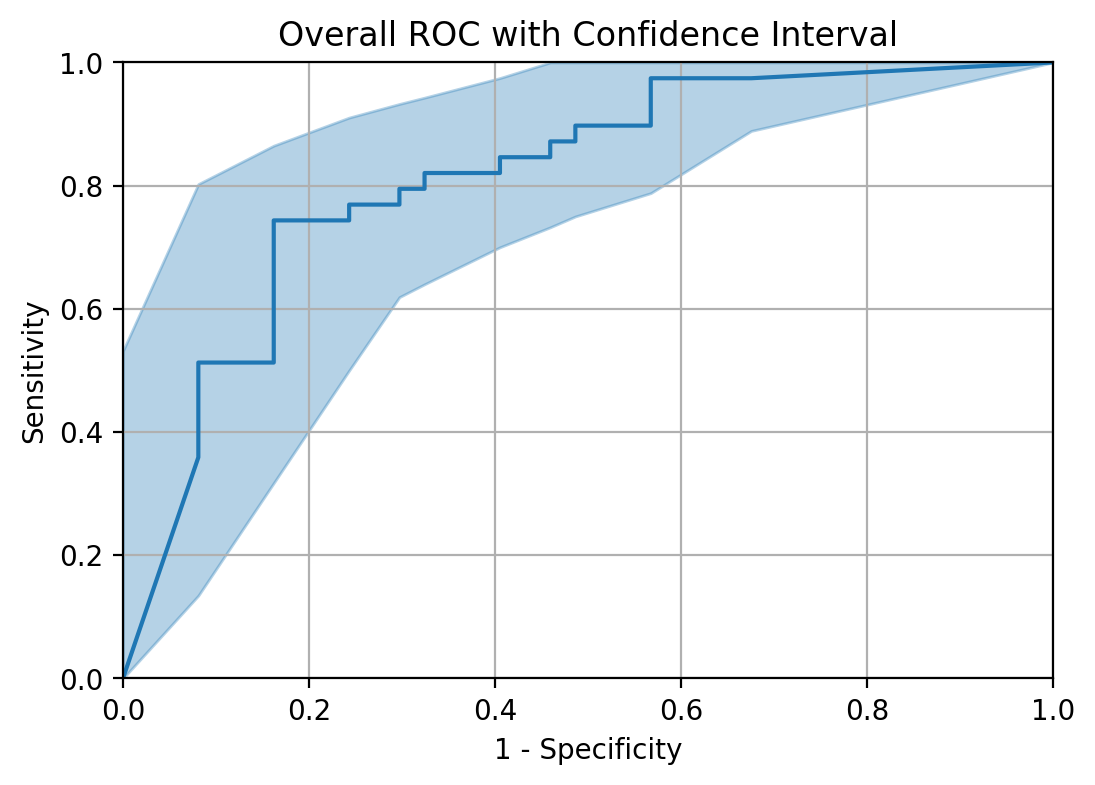

In [22]:
roc_metrics = results.output

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle = ['-', '--']
fig, ax = plt.subplots(figsize=[6, 4], dpi=200)

color = colors[0]
linestyle = linestyle_cycle[0]
tpr_ci = roc_metrics['tpr_ci']

# Plot the ROC curve and confidence interval
ax.fill_between(roc_metrics['fpr'], tpr_ci[0], tpr_ci[1], alpha=0.33, label='_nolegend_', color=color)
ax.plot(roc_metrics['fpr'], roc_metrics['tpr'], color=color, linestyle=linestyle)
ax.title.set_text('Overall ROC with Confidence Interval')
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Render the plot and save to image
buf = io.BytesIO()
fig.savefig(buf, format='png', dpi=200)
buf.seek(0)

# Load the image into PIL and save to file
image_to_store = Image.open(buf)
image_to_store.save("Overall_ROC_CI.png", format='png', optimize=True, quality=100)

# Cleanup
buf.close()

### 1.6 Calculate and plot ROC grouped by Gender

In [23]:
metric_configuration = RocAuc(y_true_variable="Pneumonia", y_pred_variable="Model Score", group_by={'groupings': ['Gender']})
results = dataset.get_metric(metric_configuration)

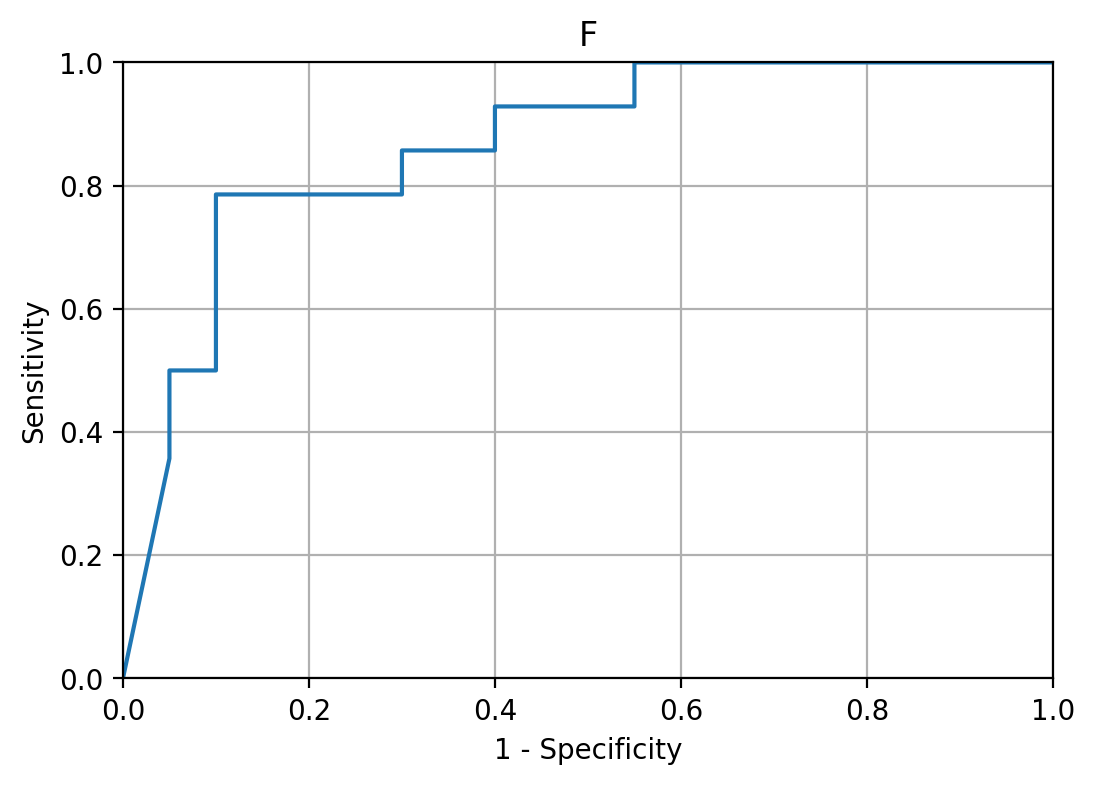

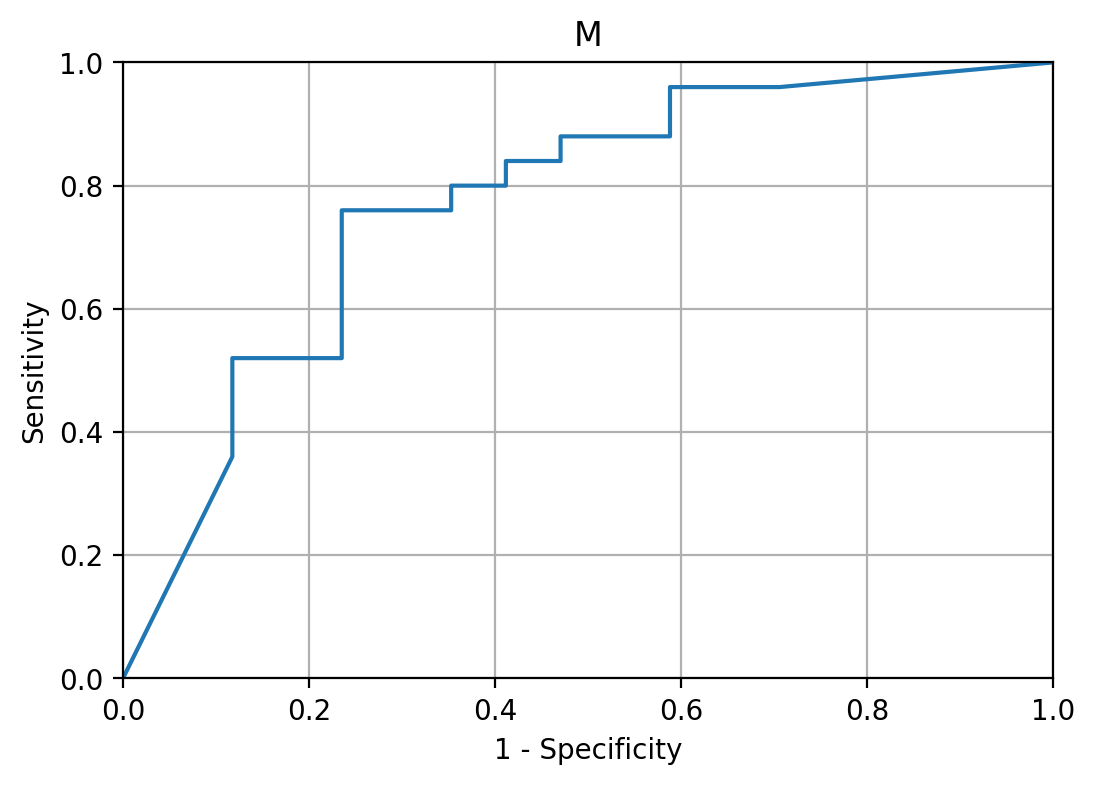

In [24]:
for group in results.output.keys():
    roc_metrics = results.output[group]
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=200)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax.plot(roc_metrics['fpr'], roc_metrics['tpr'], color=color, linestyle=linestyle)
    ax.title.set_text(group)
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Draw the canvas
    fig.canvas.draw()
    
    # Render the plot and save to image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200)
    buf.seek(0)

    # Convert to PIL Image and save to file
    image_to_store = Image.open(buf)
    image_to_store.save(f"Gender_ROC_{group}.png", format='png', optimize=True, quality=100)

    buf.close()

### 1.7 Plot the ROC by Gender on a single chart

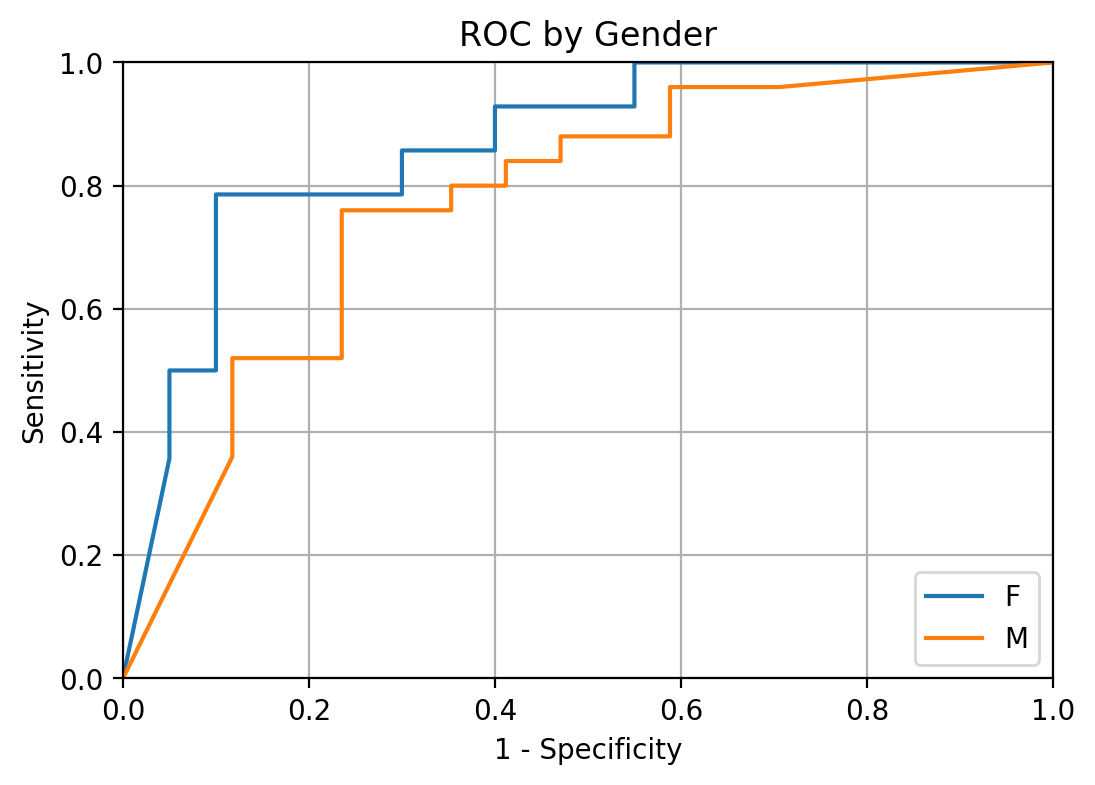

In [25]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle = ['-', '--']
fig, ax = plt.subplots(figsize=[6, 4], dpi=200)

linestyle = linestyle_cycle[0]
for group, color in zip(results.output.keys(), colors):
    roc_metrics = results.output[group]
    ax.plot(roc_metrics['fpr'], roc_metrics['tpr'], color=color, linestyle=linestyle, label=group)

ax.legend(loc='lower right')
ax.title.set_text('ROC by Gender')
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

buf = io.BytesIO()
fig.savefig(buf, format='png', dpi=200)
buf.seek(0)

image_to_store = Image.open(buf)
image_to_store.save("Gender_ROC.png", format='png', optimize=True, quality=100)

buf.close()

### 1.8 Upload the visualizations to the Rhino Health Platform

In [26]:
code_result_uid = "d62cec8c-3aca-42b9-beaa-7637a30940d3" # Paste the UID of the code run object for your NVFlare code object - look for the (V) icon

In [27]:
print("Sending visualizations to the Cloud")

def add_images_to_report(report_data, image_files):
    for image_file in image_files:
        with open(image_file, "rb") as temp_image:
            base_64_image = base64.b64encode(temp_image.read()).decode("utf-8")
            report_data.append(
              {
                 "type": "Image",
                 "data": {
                     "image_filename": image_file,
                     "image_base64": base_64_image,
                 },
                 "width": 100 / len(image_files)
              }
           )

roc_image_files = ('Overall_ROC.png', 'Overall_ROC_CI.png')
gender_image_files = ('Gender_ROC_M.png', 'Gender_ROC_F.png', 'Gender_ROC.png')

report_data = []
report_data.append({"type": "Title", "data": "Overall ROC"})
add_images_to_report(report_data, roc_image_files)
report_data.append({"type": "Title", "data": "ROC by Gender"})
add_images_to_report(report_data, gender_image_files)
    

result = session.post(f"code_runs/{code_result_uid}/set_report/", 
                      data={"report_data": json.dumps(report_data)})
print('Done')

Sending visualizations to the Cloud
Done
